# Making two snowflakes
(notebook generated by ChatGPT)

In [1]:
import numpy as np

def segment_length(seg):
    """Return the length of a segment ((x1,y1),(x2,y2))."""
    (x1, y1), (x2, y2) = seg
    return np.hypot(x2 - x1, y2 - y1)


def uniform_points_on_segments(segments, n_points):
    """
    Given a list of segments [((x1,y1),(x2,y2)), ...],
    distribute exactly n_points along them in a piecewise-uniform way.
    
    Returns:
      x_coords, y_coords: lists of length n_points
    """
    # 1) Compute the length of each segment and total length
    lengths = [segment_length(seg) for seg in segments]
    total_length = sum(lengths)
    if total_length < 1e-12:
        # Degenerate case: if total_length is zero, just return n_points at origin
        return [0]*n_points, [0]*n_points
    
    # 2) Create an array of distances where we’ll sample
    #    from 0 up to total_length (inclusive)
    distances = np.linspace(0, total_length, n_points)
    
    x_coords = []
    y_coords = []
    
    # We'll iterate through the segments while also walking along 'distances'
    seg_idx = 0            # current segment index
    seg_start_length = 0.0 # cumulative length up to the start of this segment
    
    (sx1, sy1), (sx2, sy2) = segments[seg_idx]  # first segment
    
    current_seg_len = lengths[seg_idx]
    
    # 3) Walk through each "target distance" in 'distances'
    for d in distances:
        # Move to the correct segment if 'd' exceeds the length of the current segment
        while d > seg_start_length + current_seg_len and seg_idx < len(segments) - 1:
            seg_idx += 1
            seg_start_length += current_seg_len
            (sx1, sy1), (sx2, sy2) = segments[seg_idx]
            current_seg_len = lengths[seg_idx]
        
        # 4) Now 'd' lies within the current segment
        #    Find param t from 0..1 along this segment
        seg_offset = d - seg_start_length
        t = seg_offset / current_seg_len if current_seg_len > 1e-12 else 0
        
        # Interpolate
        x = sx1 + t * (sx2 - sx1)
        y = sy1 + t * (sy2 - sy1)
        
        x_coords.append(x)
        y_coords.append(y)
    
    return x_coords, y_coords

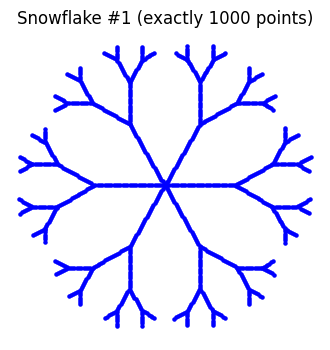

Snowflake #1 point count: 1000


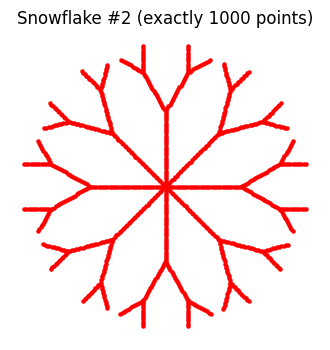

Snowflake #2 point count: 1000


In [2]:
import matplotlib.pyplot as plt

def get_branches(x, y, length, angle, depth):
    """
    Recursively build a list of line segments [((x1,y1),(x2,y2)), ...].
    """
    if depth <= 0:
        return []
    
    x2 = x + length * np.cos(angle)
    y2 = y + length * np.sin(angle)
    segments = [((x, y), (x2, y2))]
    
    if depth > 1:
        branch_length = 0.6 * length
        left_segments  = get_branches(x2, y2, branch_length, angle + np.pi/6, depth - 1)
        right_segments = get_branches(x2, y2, branch_length, angle - np.pi/6, depth - 1)
        segments += left_segments + right_segments

    return segments

# --- First Snowflake ---
num_arms_1       = 6
initial_length_1 = 1.0
max_depth_1      = 4

all_segments_1 = []
for i in range(num_arms_1):
    angle_i = 2 * np.pi * i / num_arms_1
    segs_i = get_branches(0, 0, initial_length_1, angle_i, max_depth_1)
    all_segments_1.extend(segs_i)

# Use uniform sampling to get EXACTLY 1000 points
x_points_1, y_points_1 = uniform_points_on_segments(all_segments_1, n_points=1000)

# Plot to verify
plt.figure(figsize=(4,4))
plt.scatter(x_points_1, y_points_1, s=5, color='blue')
plt.axis("equal")
plt.axis("off")
plt.title("Snowflake #1 (exactly 1000 points)")
plt.show()

print("Snowflake #1 point count:", len(x_points_1))

# --- Second Snowflake ---
num_arms_2       = 8
initial_length_2 = 1.2
max_depth_2      = 3

all_segments_2 = []
for i in range(num_arms_2):
    angle_i = 2 * np.pi * i / num_arms_2
    segs_i = get_branches(0, 0, initial_length_2, angle_i, max_depth_2)
    all_segments_2.extend(segs_i)

# Use uniform sampling to get EXACTLY 1000 points
x_points_2, y_points_2 = uniform_points_on_segments(all_segments_2, n_points=1000)

# Plot to verify
plt.figure(figsize=(4,4))
plt.scatter(x_points_2, y_points_2, s=5, color='red')
plt.axis("equal")
plt.axis("off")
plt.title("Snowflake #2 (exactly 1000 points)")
plt.show()

print("Snowflake #2 point count:", len(x_points_2))

In [3]:
import json

# Convert the first snowflake into 3D points with z=0
points_3d_aurora = [[x, y, 0] for x, y in zip(x_points_1, y_points_1)]
# Convert the second snowflake similarly
points_3d_glacier = [[x, y, 0] for x, y in zip(x_points_2, y_points_2)]

# Create a dictionary with two named snowflakes
data = {
    "SnowflakeAurora": points_3d_aurora,
    "SnowflakeGlacier": points_3d_glacier
}


In [4]:
len(points_3d_glacier)

1000

# Explanation of the Matching Algorithm
In order to pair up the points from **SnowflakeAurora** and **SnowflakeGlacier** so each pair $(i,i)$ is as close as possible in a global sense, we use the **Hungarian algorithm** (also known as the Kuhn-Munkres algorithm). The steps are:

1. **Construct a Cost Matrix**  
   We build an $N \times N$ matrix $C$, where $C[i,j]$ is the distance between the $i$-th point of Aurora and the $j$-th point of Glacier.  
   $$
   C[i,j] = \|\,(x_{\mathrm{aurora},i},\, y_{\mathrm{aurora},i}) \;-\; (x_{\mathrm{glacier},j},\, y_{\mathrm{glacier},j})\,\|.
   $$

2. **Solve the Assignment Problem**  
   We then apply `scipy.optimize.linear_sum_assignment(C)`, which returns two arrays:
   - `row_ind` (the indices in Aurora)
   - `col_ind` (the matched indices in Glacier)  
   such that the total sum of distances 
   $$
   \sum_{i=0}^{N-1} C[\text{row\_ind}[i],\, \text{col\_ind}[i]]
   $$
   is **minimized**.

3. **Reorder the Glacier Points**  
   We reorder Glacier’s points using `col_ind` so that:
   $$
   \text{GlacierMatched}[i] = \text{GlacierOriginal}[\text{col\_ind}[i]].
   $$
   This ensures that `GlacierMatched[i]` is now the point from Glacier that best pairs with Aurora’s $i$-th point, minimizing the **overall** total distance.

Hence, **point $i$** in Aurora corresponds to **point $i$** in the matched Glacier set, allowing you to animate or morph between the two snowflakes with minimal distortion.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Suppose points_3d_aurora and points_3d_glacier each have EXACTLY 1000 points 
# in the format [[x0, y0, 0], [x1, y1, 0], ..., [x999, y999, 0]]

# 1) Convert to NumPy arrays for easier numeric manipulation
arr_aurora = np.array(points_3d_aurora)   # shape (1000, 3)
arr_glacier = np.array(points_3d_glacier) # shape (1000, 3)

# We only need x,y for distances (z=0 for all). 
# So let's slice them down to shape (1000, 2).
aurora_xy  = arr_aurora[:, 0:2]
glacier_xy = arr_glacier[:, 0:2]

# 2) Build the cost matrix of Euclidean distances
#    cost_matrix[i,j] = distance between aurora_xy[i] and glacier_xy[j].
#    If you prefer squared distances, you can use squared norms instead.
cost_matrix = np.linalg.norm(
    aurora_xy[:, None, :] - glacier_xy[None, :, :], 
    axis=2
)  
# cost_matrix will be shape (1000, 1000)

# 3) Solve the assignment problem
#    row_ind[i], col_ind[i] gives the best pairing: 
#    "i-th Aurora point is paired with col_ind[i]-th Glacier point".
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 4) Reorder the second snowflake's points so that 
#    arr_glacier_matched[i] is the point from Glacier matched to Aurora[i].
arr_glacier_matched = arr_glacier[col_ind]

# Convert back to a Python list if desired
points_3d_glacier_matched = arr_glacier_matched.tolist()

print("Matching complete.")
print("Now points_3d_aurora[i] is close to points_3d_glacier_matched[i].")

# Optional: check the average distance
distances = np.linalg.norm(aurora_xy - arr_glacier_matched[:,0:2], axis=1)
print(f"Average distance after matching: {distances.mean():.4f}")

Matching complete.
Now points_3d_aurora[i] is close to points_3d_glacier_matched[i].
Average distance after matching: 0.2060


In [6]:
import json

# Assume you've already done:
# 1) arr_aurora (1000 x 3) = first snowflake
# 2) arr_glacier_matched (1000 x 3) = second snowflake re-ordered/matched
# 3) Converted them to Python lists: points_3d_aurora, points_3d_glacier_matched

data_matched = {
    "SnowflakeAurora": points_3d_aurora,               # the original Aurora points (3D)
    "SnowflakeGlacierMatched": points_3d_glacier_matched  # the Glacier points matched to Aurora
}

with open("two_snowflakes_matched.json", "w") as f:
    json.dump(data_matched, f, indent=2)

print("Matched snowflakes saved to two_snowflakes_matched.json.")

Matched snowflakes saved to two_snowflakes_matched.json.
